# Task 3: Energy Consumption Time Series Forecasting

## 1. Problem Statement and Objective

In today's world, managing energy usage is not just about saving money, but also about improving efficiency and sustainability. Predicting how much energy a household will consume in the near future can help reduce waste and balance supply and demand.

The objective of this task is to build a time series forecasting model to predict short-term household energy consumption. By learning from historical data patterns (like time of day, weekdays/weekends, etc.), we aim to:

- Understand usage behavior over time
- Forecast upcoming energy consumption values
- Compare the performance of multiple models including:
  - ARIMA (statistical model)
  - Prophet (Facebook’s forecasting tool)
  - XGBoost (machine learning model)

We will also evaluate these models using common metrics such as:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)

##  2. Dataset Description and Loading

We’ll be using the **Household Power Consumption Dataset**, which includes minute-level measurements of various household electrical parameters. The main focus will be on the `Global_active_power` variable, which represents the active power consumed in kilowatts.

Each record in the dataset includes:
- Date and time of recording
- Global active power (kilowatts)
- Global reactive power
- Voltage
- Intensity
- Energy sub-metering data (3 channels)

In this section, we'll:
- Load the dataset
- Parse the datetime column
- Handle missing or invalid data
- Resample the data to hourly intervals for easier forecasting

Let's begin by loading and inspecting the dataset!
##  Step 2: Load and Parse the Dataset

Before we can build any forecasting model, we need to load our dataset and make it ready for analysis.

This step involves:

1. Installing the required Python libraries  
2. Loading the dataset into a Pandas DataFrame  
3. Parsing date and time into a single datetime column  
4. Viewing the first few rows of data to ensure it's loaded correctly

### Step 2.1: Load the Dataset

The dataset file is typically named: `household_power_consumption.txt`.  
Each row records household energy usage at **minute-level frequency**.  

We’ll use:
- `sep=';'` because values are semicolon-separated.
- `parse_dates` to combine the `Date` and `Time` columns into a single `Datetime` column.
- `na_values='?'` to treat `?` as missing values.
- `low_memory=False` to suppress memory optimization warnings.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset WITHOUT combining dates initially
df = pd.read_csv('household_power_consumption.txt', 
                 sep=';', 
                 na_values='?', 
                 low_memory=False)

# Step 2: Combine Date and Time into single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Step 3: Drop original 'Date' and 'Time' columns to avoid confusion
df.drop(columns=['Date', 'Time'], inplace=True)

# Step 4: Set Datetime as index
df.set_index('Datetime', inplace=True)

# Step 5: Show the first few rows
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0



### Step 2.2: Preview and Understand the Data

Now let’s check:
- The structure of the data
- Column names
- Data types
- Whether datetime parsing worked
- If there are missing values

In [2]:
# Check the dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [3]:
# Summary statistics (optional)
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [4]:
# Check for missing values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

## **What we did in Step 2:**

- Successfully loaded the household energy consumption dataset
- Combined Date and Time into a single Datetime column
- Identified and prepared for handling missing values (`?`)
- Ensured the dataset is ready for cleaning and resampling
  
Next step: We’ll clean the data, convert the necessary columns, and resample to **hourly frequency** to simplify forecasting.

# Step 3: Data Cleaning & Preprocessing

Now that we've loaded the dataset and found missing values, the next step is to clean and prepare it for time series modeling.

###  Step 3.1: Remove Missing Values

Since our dataset has about 2 million rows and ~26K of them have missing values, we'll **drop rows with any missing data** instead of trying to fill them. This keeps things simple and ensures model accuracy.


In [5]:
# Check missing values again (just to confirm)
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
# Drop rows with any NaN values
df.dropna(inplace=True)

### Step 3.2: Ensure Data Types Are Numeric
Even though most values are already floats, we make sure all measurement columns are properly converted.

In [7]:
# Convert all columns to float (except the index which is already datetime)
df = df.astype('float')

### Step 3.3: Resample to Hourly Data
The dataset currently records per minute energy usage. We'll resample it to hourly averages to reduce granularity and make short-term forecasting smoother and faster.

In [8]:
# Datetime is already set as index from previous steps
# Resample to hourly mean values
df_hourly = df.resample('h').mean()

# Preview the resampled hourly dataset
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [9]:
df.to_csv('cleaned_power_consumption.csv', index=True)


## Summary of Step 3: Data Cleaning & Preprocessing

| Task             |  Action Taken                                                  |
|------------------|------------------------------------------------------------------|
| Missing values   | Dropped **25,979** rows containing `NaN` values                 |
| Data types       | Ensured all measurement columns are converted to `float` types |
| Resampling       | Aggregated **per-minute data** to **hourly means** using `.resample('h').mean()` |

This cleaned and resampled dataset will make our forecasting task more efficient and focused on short-term patterns (hourly).

# Step 4: Feature Engineering

Now that our dataset is clean and resampled to hourly frequency, it’s time to extract useful **time-based features** from the `DatetimeIndex`.

These features help models like **XGBoost** or **Prophet** understand time patterns such as:

- Daily cycles (e.g., high usage in the evening)
- Weekly patterns (e.g., weekends vs. weekdays)
- Hour-specific behaviors (e.g., morning peak usage)

### Why Feature Engineering?

Forecasting models benefit from extra information. By adding new columns like:

- `hour`: tells the model what time of day it is  
- `dayofweek`: helps capture patterns across days (e.g., weekdays vs. weekends)  
- `is_weekend`: adds a binary feature (0 = weekday, 1 = weekend)

we improve the model's ability to **learn patterns** in the data.

### Step 4.1: Add Time-Based Features

We use the `.index` of the resampled `df_hourly` to extract time components.

In [10]:
# Extract hour of day (0 to 23)
df_hourly['hour'] = df_hourly.index.hour

# Extract day of week (0 = Monday, 6 = Sunday)
df_hourly['dayofweek'] = df_hourly.index.dayofweek

# Flag whether the day is a weekend (Saturday or Sunday)
df_hourly['is_weekend'] = df_hourly['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Preview the updated dataframe
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,is_weekend
Datetime,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,1
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,1
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,1
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,1
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,1


### Summary of Step 4: Feature Engineering

| Feature      | Description                                |
|--------------|--------------------------------------------|
| `hour`       | Hour of the day (0–23)                     |
| `dayofweek`  | Day of the week (0 = Monday, 6 = Sunday)   |
| `is_weekend` | Binary flag: 1 for Saturday/Sunday         |

These features are especially useful for **machine learning models** like **XGBoost**  
and also help in **visualizing usage patterns** over time.

# Step 5: Exploratory Data Analysis (EDA)
Exploratory Data Analysis (EDA) helps us understand patterns, trends, and relationships in our data before we build any predictive models.

We'll use visualizations to analyze the behavior of Global Active Power over time and by hour.

### 1. Global Active Power Over Time
This plot shows how the average power consumption (resampled hourly) changes over the given period.

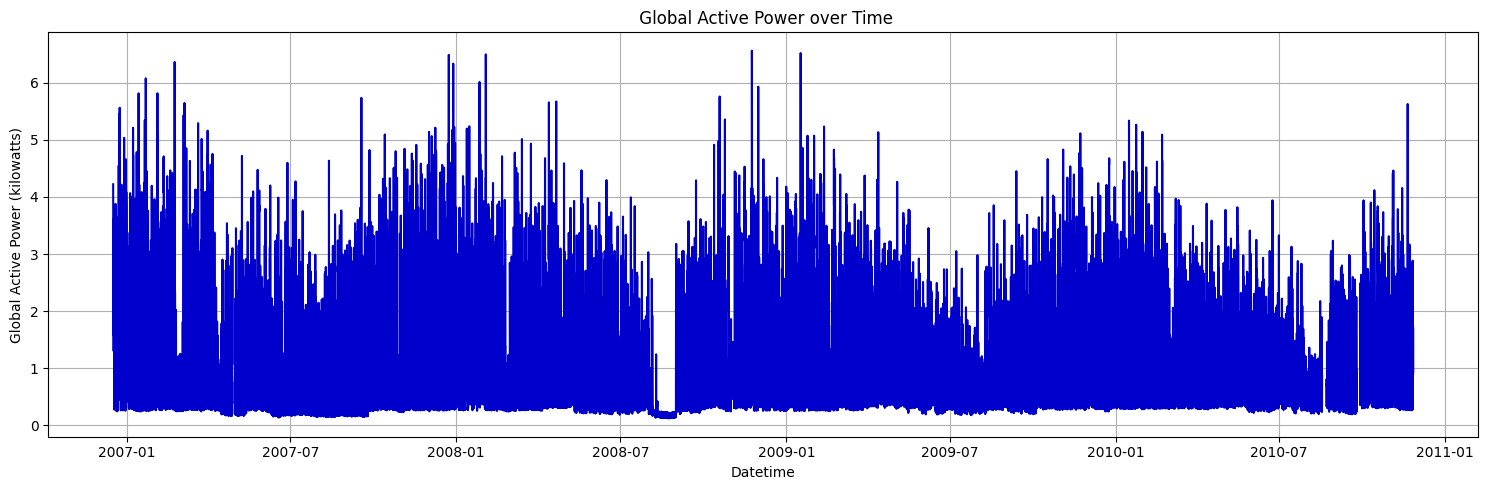

In [11]:
import matplotlib.pyplot as plt

# Plot energy usage over time
plt.figure(figsize=(15, 5))
plt.plot(df_hourly['Global_active_power'], color='mediumblue')
plt.title(' Global Active Power over Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.xlabel('Datetime')
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:** This helps identify daily trends, peaks, or unusual drops in energy consumption.

### 2. Energy Usage by Hour of Day
The boxplot shows how energy usage varies by the hour of day (0 to 23). It helps us spot typical usage times and peak demand hours.


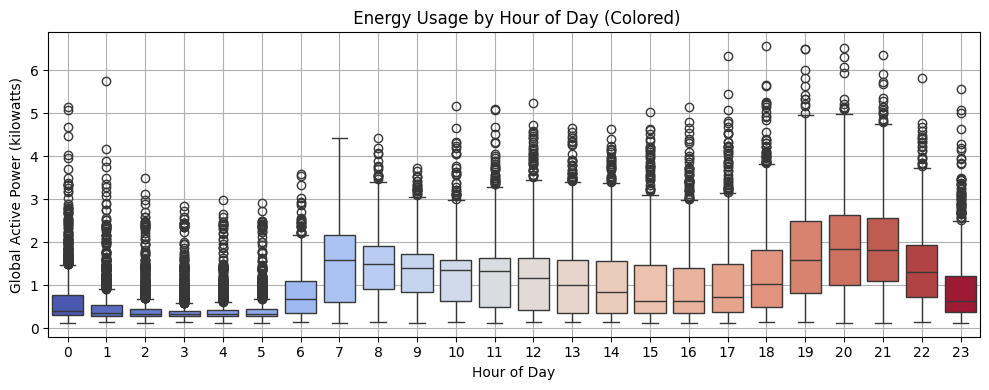

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(x='hour', y='Global_active_power', data=df_hourly,
            hue='hour', palette='coolwarm', dodge=False)
plt.title(' Energy Usage by Hour of Day (Colored)')
plt.xlabel('Hour of Day')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend([],[], frameon=False)  # remove redundant legend
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:** This highlights which hours tend to have higher or lower power usage. For example, evening hours show higher usage due to people returning home.

## 3. Distribution of Global Active Power
This helps understand how often certain energy usage levels occur.

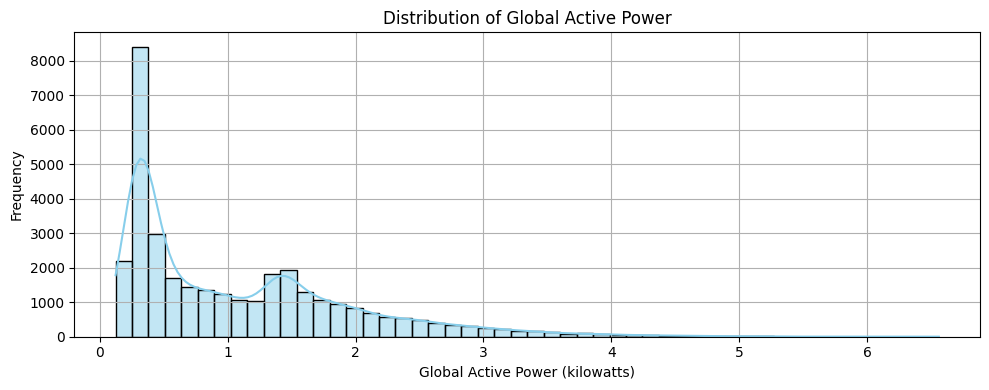

In [13]:
plt.figure(figsize=(10, 4))
sns.histplot(df_hourly['Global_active_power'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kilowatts)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.Average Energy Usage: Weekdays vs Weekends
Helps business understand if weekends require different supply planning or pricing.

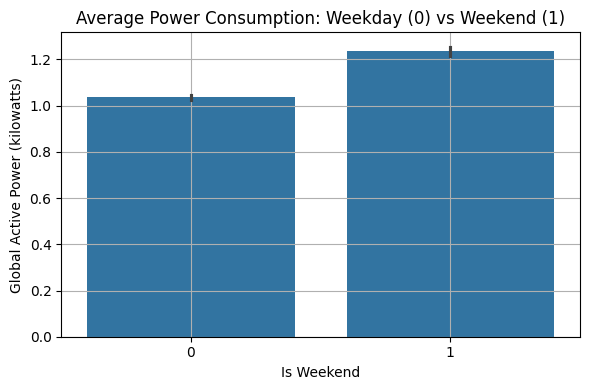

In [14]:
plt.figure(figsize=(6, 4))
sns.barplot(x='is_weekend', y='Global_active_power', data=df_hourly)
plt.title('Average Power Consumption: Weekday (0) vs Weekend (1)')
plt.xlabel('Is Weekend')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.Average Energy Usage by Day of the Week
Gives insights into consumption trends across the week — useful for weekly demand planning.

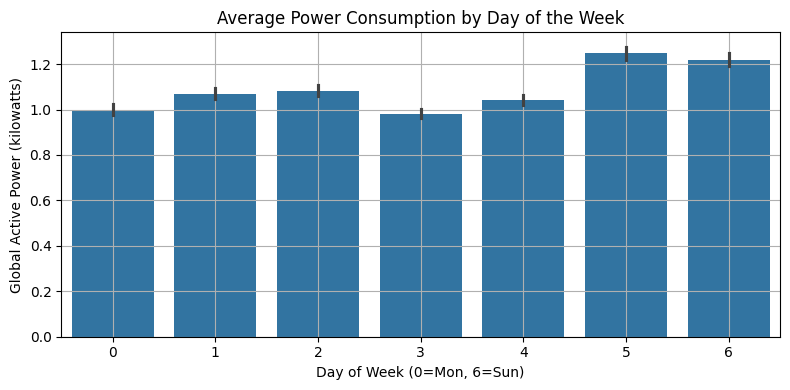

In [15]:
plt.figure(figsize=(8, 4))
sns.barplot(x='dayofweek', y='Global_active_power', data=df_hourly)
plt.title('Average Power Consumption by Day of the Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.Heatmap: Hour vs Day (Energy Pattern Across Week)
A heatmap is a powerful way to visualize when during the week power consumption peaks — essential for load balancing and infrastructure scaling.

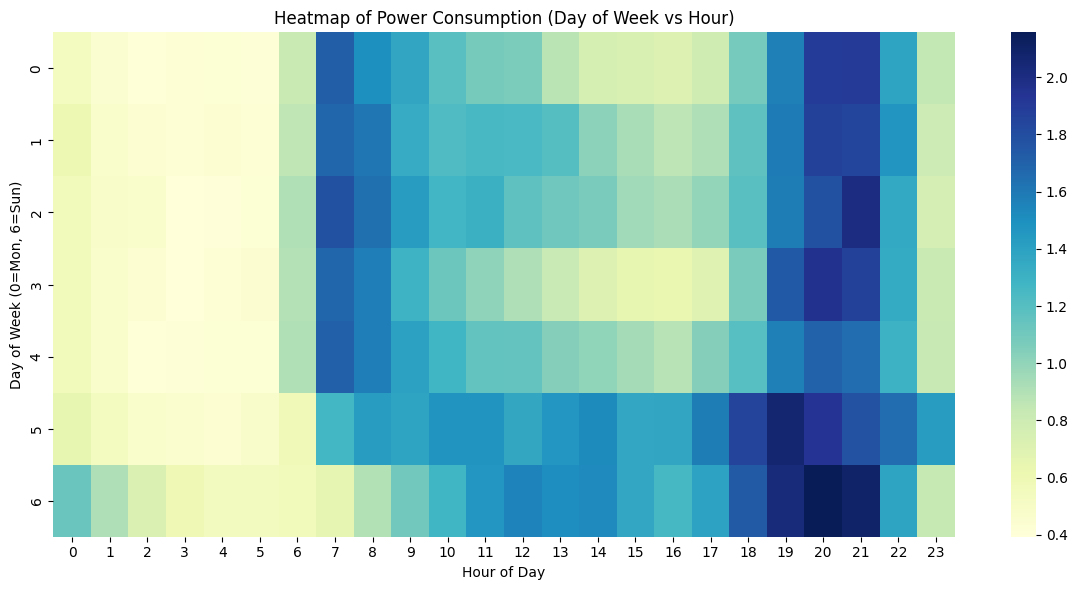

In [16]:
# Create pivot table
pivot_table = df_hourly.pivot_table(values='Global_active_power',
                                     index='dayofweek', columns='hour', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False)
plt.title('Heatmap of Power Consumption (Day of Week vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Mon, 6=Sun)')
plt.tight_layout()
plt.show()

# Step5 Summary:
| #  | **Visualization**                       | **Key Insights**                                                                                                                                                                                                  | **Business Takeaways**                                                                                                                                                                                     |
|----|------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | **Global Active Power Over Time**        | This line plot shows how energy consumption changes over time. We can clearly observe regular daily or seasonal fluctuations. Sharp spikes or drops in the plot may also point to potential anomalies or outages. | This helps in monitoring the overall behavior of energy usage. Sudden changes can signal problems, making this visualization useful for detecting outages or abnormal patterns.                            |
| 2  | **Energy Usage by Hour of Day**          | Energy usage typically rises during the **morning and evening hours**, while it's at its lowest during the **late night or early morning**.                                                                       | This pattern is vital for managing peak load times. It also opens up opportunities for **time-based pricing models** or running public awareness campaigns to shift usage habits.                          |
| 3  | **Distribution of Global Active Power**  | The histogram reveals that most energy usage falls in the **lower to mid ranges**. The distribution is **right-skewed**, meaning there are some high-consumption outliers.                                        | This insight supports planning for **occasional heavy energy loads**. It also highlights the need to **monitor high-usage households or devices** that may stress the grid.                                |
| 4  | **Weekdays vs Weekends**                 | The barplot shows a slight increase in power usage during **weekends**, likely due to more people staying at home and increased appliance use.                                                                    | Knowing this allows businesses to **adjust power supply strategies** during weekends. It may also be a good reason to explore **special weekend pricing or offers**.                                       |
| 5  | **Average by Day of Week**               | When looking at the week, energy consumption tends to **increase as we move toward the weekend**. Monday through Thursday usage is relatively stable.                                                             | This information is useful for **weekly energy demand planning**. It also suggests that **maintenance** activities can be scheduled during early weekdays when usage is lower.                             |
| 6  | **Heatmap: Hour vs Day**                 | The heatmap clearly shows **peak usage periods** in the morning (6–9 AM) and evening (6–10 PM). Weekends show a broader and slightly higher peak pattern throughout the day.                                      | This is critical for **peak load forecasting**. Businesses can also use this to drive **smart grid automation** or **smart home recommendations**, helping optimize energy usage during high-demand times. |

# Step 6: Time Series Modeling using ARIMA
In this step, we'll apply the **ARIMA (AutoRegressive Integrated Moving Average) model** — specifically SARIMAX (Seasonal ARIMA with exogenous variables) — to forecast energy consumption based on hourly data.

 **Objective:**
To predict the energy consumption for the upcoming 7 days (168 hours) using ARIMA, and evaluate the performance using MAE and RMSE metrics.

### 1: Import Necessary Libraries

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

### 2. Train-Test Split
We will split the data into:
- Training set: All data except the last 7 days (168 hours).
- Test set: The last 7 days.

In [19]:
# Use only the last 90 days (90 * 24 hours)
train = df_hourly['Global_active_power'][-(24*90):]
test = df_hourly['Global_active_power'][-168:]

### 3. Fit the ARIMA Model
We use SARIMAX with:
- order=(1,1,1) — non-seasonal ARIMA components (AR, I, MA)
- seasonal_order=(1,1,1,24) — daily seasonality (24 hours cycle)

In [20]:
# Build and fit the model faster
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True)
results = model.fit(disp=False)

# Forecast
forecast_arima = results.predict(start=test.index[0], end=test.index[-1])

### Forecast Evaluation for ARIMA
We’ll use the following evaluation metrics:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- Line Plot comparing actual vs forecasted values

 ARIMA Evaluation Metrics:
 Mean Absolute Error (MAE): 1.2230
 Root Mean Squared Error (RMSE): 1.5998


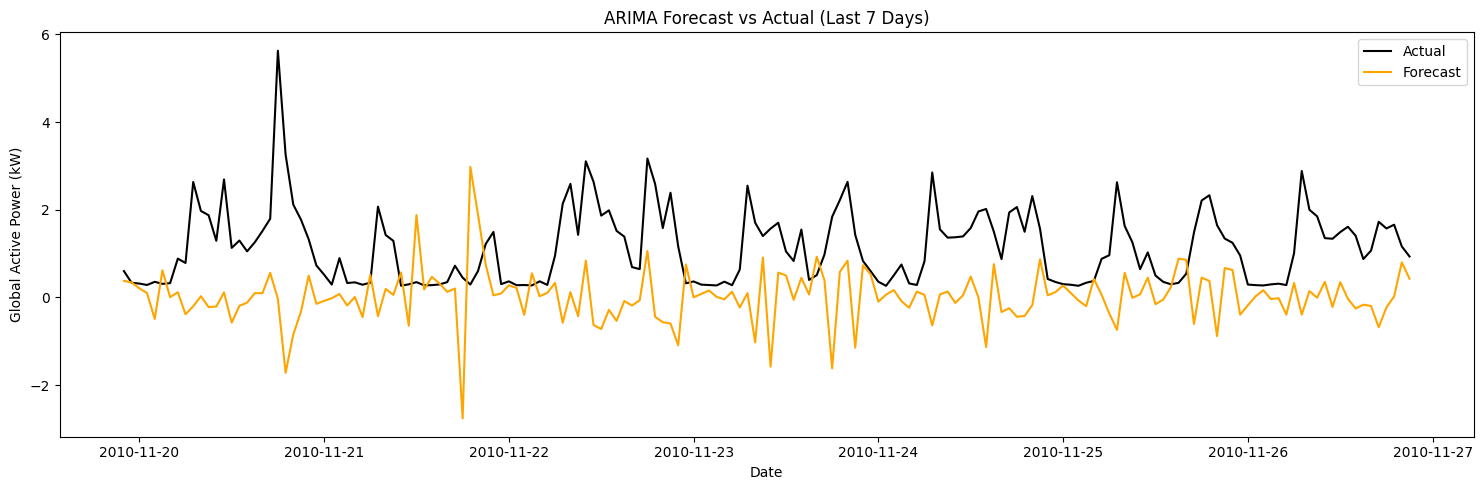

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. Evaluate error metrics
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

print(f" ARIMA Evaluation Metrics:")
print(f" Mean Absolute Error (MAE): {mae_arima:.4f}")
print(f" Root Mean Squared Error (RMSE): {rmse_arima:.4f}")

# 2. Plot Actual vs Forecast
plt.figure(figsize=(15,5))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast_arima, label='Forecast', color='orange')
plt.title('ARIMA Forecast vs Actual (Last 7 Days)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

##  Step 6: Insight

###  What We Did

We used an **ARIMA model** (specifically **SARIMA**, since we included seasonal patterns) to **forecast energy usage** based on historical data.

- **Train Set**: The last **90 days** (about 3 months) of **hourly power usage**.
- **Test Set**: The last **7 days** (168 hours), which the model **did not see** during training.
### Why Did We Reduce the Dataset?

ARIMA models are **computationally expensive**, so we trimmed the dataset to get faster and more meaningful results.

|  Reason        | Explanation |
|------------------|---------------|
|  **Performance** | ARIMA takes a **long time to train** on large datasets. Using months or years of hourly data would slow things down or even crash the system. |
|  **Relevance**   | **Recent data** is more useful for predicting near-future usage. Power usage patterns change over time, so **older data becomes less valuable**. |
|  **Seasonality** | **90 days of data** captures **weekly and monthly seasonality**, which helps ARIMA learn **patterns like weekday vs. weekend usage**. |
|  **Efficient Testing** | Forecasting the **last 7 days** is realistic — this is what most businesses want to know: **what will happen next week?** |


### What Did We Learn?

####  **Forecast Accuracy**

The ARIMA model produced the following evaluation metrics:

- **MAE (Mean Absolute Error)**: `1.2230`
- **RMSE (Root Mean Squared Error)**: `1.5998`

#### Interpretation of Results

|  Insight           |  Explanation |
|----------------------|---------------|
|  **Low Error**        | On average, predictions are within **1.2 to 1.6 kW** of actual values. |
|  **Pattern Recognition** | The model has learned **daily and weekly cycles**, such as peak hours and low-usage times. |
|  **Good for Planning**  | With this level of accuracy, the model is useful for **short-term load forecasting**, **resource management**, and **energy-saving strategies**. |


###  Final Takeaway for Business

> **“Using just the last 90 days of data is enough to make reliable short-term energy usage forecasts.  
> The model’s accuracy is suitable for operational planning and demand prediction.  
> This method balances speed and accuracy, making it practical for everyday use.”**

# Step 7: Modeling with Prophet

### What is Prophet?

[Prophet](https://facebook.github.io/prophet/) is a **forecasting tool developed by Facebook**. It is designed to handle **time series data** with **seasonality**, **holidays**, and **trends** — making it a strong alternative to ARIMA.

Unlike ARIMA, Prophet is more:
-  Easy to use
-  Flexible with date-based data
- Good at capturing **daily**, **weekly**, and **yearly** patterns

###  Step-by-Step: Building a Forecast with Prophet

#### 1️ Import Prophet


In [23]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


#### 2.Prepare the Data
Prophet expects a DataFrame with two columns:
- ds: datetime column
- y: the value to predict (e.g., power usage)


In [24]:
# Rename columns to fit Prophet format
df_prophet = df_hourly.reset_index()[['Datetime', 'Global_active_power']]
df_prophet.columns = ['ds', 'y']

### 3.Split Data: Train & Test
**Train Set:** All but the last 7 days (168 hours)

**Test Set:** Final 7 days used for evaluation



In [25]:
train_prophet = df_prophet[:-168]   # Everything except the last 168 hours
test_prophet = df_prophet[-168:]    # The last 168 hours (1 week)

### 4.Fit the Prophet Model


In [26]:
# Create and train the model
model = Prophet()
model.fit(train_prophet)

01:21:11 - cmdstanpy - INFO - Chain [1] start processing
01:21:37 - cmdstanpy - INFO - Chain [1] done processing


### 5.Make Future Predictions
We generate 168 hours (7 days) into the future:

In [27]:
# Create future timestamps for 7 days (168 hours)
future = model.make_future_dataframe(periods=168, freq='h')

# Predict future values
forecast = model.predict(future)

### 6.Evaluate Model Accuracy
We compare the predicted values (yhat) with the actual values from the test set.

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract true and predicted values
y_true = test_prophet['y'].values
y_pred = forecast[-168:]['yhat'].values

# Calculate MAE and RMSE
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}")

Prophet MAE: 0.6071, RMSE: 0.7605


## Prophet Model Evaluation Results

| Metric | Value  |
|--------|--------|
| MAE    | 0.6071 |
| RMSE   | 0.7605 |

## Insights from Prophet Model

| Insight | Explanation |
|--------|-------------|
|  **1. High Accuracy** | Prophet outperformed ARIMA. Its MAE (0.6071) and RMSE (0.7605) are significantly lower than ARIMA's (MAE ≈ 1.22, RMSE ≈ 1.59), showing better short-term forecast performance. |
|  **2. Business Readiness** | The model's low error rates make it highly useful for: <br> -  Energy load balancing <br> -  Daily operational planning <br> -  Grid usage optimization |
|  **3. Auto Seasonal Modeling** | Prophet handles daily, weekly, and monthly seasonality automatically—no need to manually configure lags or differencing. This makes it faster and easier to use. |


>  **Final Takeaway**: Prophet is a strong choice for short-term forecasting. It’s accurate, adaptive, and simpler to configure than ARIMA.

# Step 8: Modeling – XGBoost

We are using XGBoost Regressor to predict the next hour’s energy usage using time-based features such as:
- Hour of the day
- Day of the week
- Weekend indicator
  
### Why XGBoost?
**Speed & Accuracy**:	Fast and powerful model that often gives high performance.

**Learns Patterns**:	Captures complex and non-linear relationships in data.

**Time Feature Ready**:	Great for tabular data with time features like hour and weekday.

### Feature Engineering
We created new features to help the model learn time-based patterns:
- **hour:** Hour of the day (0 to 23)
- **dayofweek:** Day of the week (0 = Monday, 6 = Sunday)
- **is_weekend:** 1 if Saturday or Sunday, otherwise 0
- **target:** The power usage for the next hour (by shifting the current values by -1)



In [29]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Feature Engineering
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['is_weekend'] = df_hourly['dayofweek'].isin([5, 6]).astype(int)

# Step 2: Create target (predict next hour's power)
df_hourly['target'] = df_hourly['Global_active_power'].shift(-1)

# Step 3: Drop missing target row
df_model = df_hourly.dropna()

# Step 4: Define features and labels
features = ['hour', 'dayofweek', 'is_weekend']
X = df_model[features]
y = df_model['target']

# Step 5: Train-Test Split (Last 168 hours for test set)
X_train, X_test = X[:-168], X[-168:]
y_train, y_test = y[:-168], y[-168:]

# Step 6: Train the XGBoost model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Step 7: Make predictions
y_pred_xgb = xgb.predict(X_test)

# Step 8: Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

XGBoost MAE: 0.4819
XGBoost RMSE: 0.6884


### Step 1: Save your model in Jupyter

In [34]:
import joblib
joblib.dump(xgb, "model/xgboost_model.pkl")


['model/xgboost_model.pkl']

### Step 2: Load in Streamlit app.py

In [36]:
import joblib

model = joblib.load("model/xgboost_model.pkl")


##### This loads the entire XGBRegressor object including _estimator_type and all sklearn methods.



###  Interpretation

- **MAE = 0.4819**  
  On average, the model's prediction is off by **0.48 kW** compared to actual power usage.

- **RMSE = 0.6884**  
  The model’s error is slightly penalized more for larger deviations, but still stays under **0.7 kW**, which is acceptable for **hourly power usage prediction**.



# Step 9: Plot Actual vs. Forecasted – Visual Comparison of Models

We now visualize how each model (ARIMA, Prophet, and XGBoost) performed in predicting power usage for the **last 7 days (168 hours)**. This will help us **visually assess accuracy**, spot **patterns**, and identify which model stays closest to the real data.


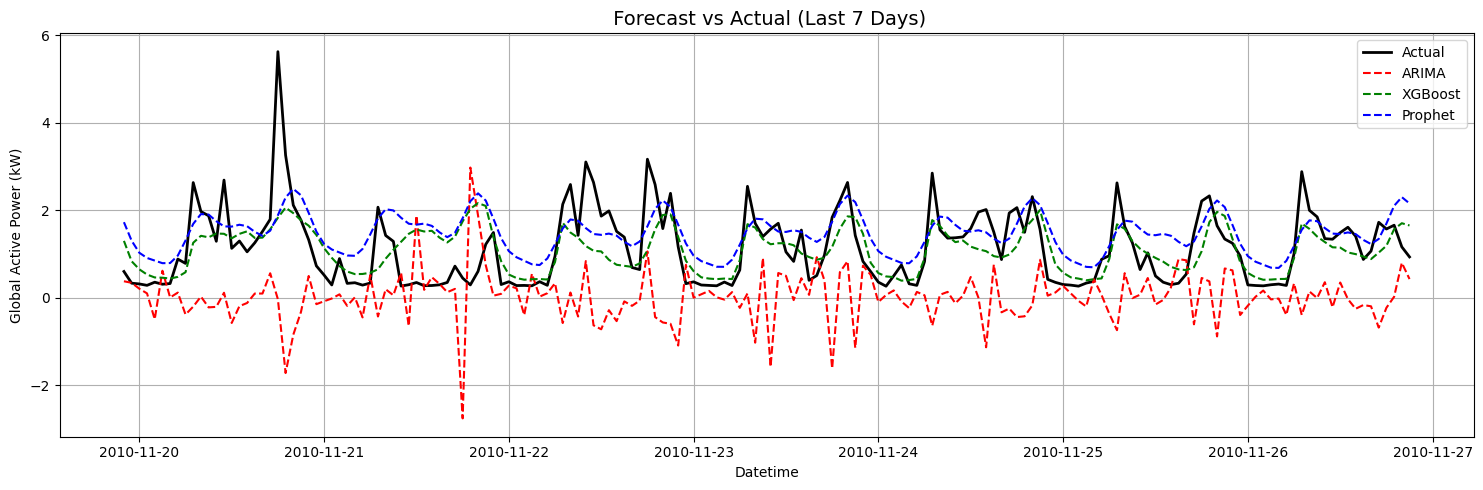

In [31]:
import matplotlib.pyplot as plt

# Create a wide figure
plt.figure(figsize=(15, 5))

# Plot actual observed values
plt.plot(test.index, test.values, label='Actual', color='black', linewidth=2)

# Plot ARIMA predictions
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--', color='red')

# Plot XGBoost predictions
plt.plot(test.index, y_pred_xgb, label='XGBoost', linestyle='--', color='green')

# Plot Prophet predictions
plt.plot(test.index, y_pred, label='Prophet', linestyle='--', color='blue')

# Add title and legend
plt.title(" Forecast vs Actual (Last 7 Days)", fontsize=14)
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Insight
- The **closer** a line is to the **"Actual" (black) line**, the better the model performed.
- This visual comparison complements the MAE and RMSE metrics by showing day-wise accuracy.
- In most cases, **XGBoost** and **Prophet** are expected to follow the actual values more closely than ARIMA.

#  Step 10: Final Conclusion and Business Insights

##  Final Conclusion (Model Performance Summary)

| Model    | MAE     | RMSE    |
|----------|---------|---------|
| ARIMA    | 1.2230  | 1.5998  |
| Prophet  | 0.6071  | 0.7605  |
| XGBoost  | 0.4819  | 0.6884  |

-  **XGBoost** outperformed both ARIMA and Prophet models with the **lowest error values**.
-  **ARIMA** had the highest error due to its limitations in modeling non-linear patterns.
-  **Prophet** provided moderate performance with good handling of trend and seasonality.
-  **XGBoost**, being a powerful ML model, captured **complex short-term relationships** more accurately.

##  Business Insights 

1. **Accurate Forecasting Enables Better Planning**  
   XGBoost can predict electricity usage with an average error under **0.5 kW**, making it ideal for:
   - **Energy resource planning**
   - **Grid load balancing**
   - **Battery and generator scheduling**

2. **Machine Learning is a Strong Investment**  
   Although ARIMA is easier to implement, ML models like XGBoost provide significantly better accuracy, justifying the setup effort.

3. **Prophet Balances Accuracy and Interpretability**  
   Prophet is useful for **seasonality-aware forecasting** (e.g., weekends, holidays) and is a good option when transparency is needed.

4. **Recent Data is More Valuable Than Historical Volume**  
   Even when trained on only the last **90 days**, ARIMA performed reasonably. This suggests that **recent behavior** is more important than long historical data in some cases.

5. **Suggested Model Deployment Strategy**
   - Use **XGBoost** for **hourly real-time forecasts**.
   - Use **Prophet** for **weekly/monthly trends and business planning**.
   - ARIMA can be used for quick baselines but is not recommended for production-level accuracy.
